<a href="https://colab.research.google.com/github/lszam/potentials-on/blob/main/PosdocON_GravCamposSantosRibeira_Etapa02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ambiente**

##Bibliotecas e funções

In [42]:
!pip install geopandas shapely matplotlib zipfile36 verde -q

import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import zipfile
import shutil
import verde as vd
import requests

from shapely.geometry import Polygon


In [43]:
!pip install pystac-client pyproj rasterio -q

In [44]:
from shapely.geometry import shape, Polygon, mapping

from pyproj import Transformer, CRS

import rasterio
from rasterio.plot import show
from rasterio.mask import mask

In [45]:
!apt-get install -y gdal-bin python3-gdal
!gdalinfo --version

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gdal-bin is already the newest version (3.8.4+dfsg-1~jammy0).
python3-gdal is already the newest version (3.8.4+dfsg-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
GDAL 3.8.4, released 2024/02/08


In [46]:
!pip install cmocean -q

In [47]:
import cmocean

In [48]:
def plot_gdf_scatter(x, y, c, cmap, title):
    try:
      import cmocean
    except:
      !pip install cmocean -q
      import cmocean

    fig, ax = plt.subplots(figsize=(8, 6))
    sc = ax.scatter(
        x, y,
        c=c,
        cmap=cmap,
        s=2,
        alpha=0.8,
        linewidth=0
    )
    ax.set_xlabel("Easting")
    ax.set_ylabel("Northing")
    ax.set_title(title)
    ax.set_aspect("equal", adjustable="box")
    cbar = fig.colorbar(sc, ax=ax, shrink=0.7, pad=0.02)
    cbar.set_label(title)
    plt.grid(True, linewidth=0.3, alpha=0.5)
    plt.tight_layout()
    plt.show()

## Configurar área de estudo

Sistema de coordenadas personalizado - policônica com datum sirgas 2000 (EPSG ?)

In [49]:
from pyproj import CRS

# String do .prj
wkt_string = '''PROJCS["Polyconic_Brasil",GEOGCS["GCS_SIRGAS_2000",
DATUM["D_SIRGAS_2000",SPHEROID["GRS_1980",6378137,298.257222101]],
PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],
PROJECTION["Polyconic"],PARAMETER["False_Easting",5000000],
PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",-54],
PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]'''

# Criar o objeto CRS a partir do WKT
crs_projeto = CRS.from_wkt(wkt_string)

# Verificar o CRS
print(crs_projeto)

PROJCS["Polyconic_Brasil",GEOGCS["GCS_SIRGAS_2000",
DATUM["D_SIRGAS_2000",SPHEROID["GRS_1980",6378137,298.257222101]],
PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],
PROJECTION["Polyconic"],PARAMETER["False_Easting",5000000],
PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",-54],
PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]


In [50]:
shapefile_path = "janela-ptrII_pg.shp"

#Criar polígono do entorno
aoi_gdf = gpd.read_file(shapefile_path)
aoi_gdf['geometry'] = aoi_gdf['geometry'].buffer(0) # corrige geometrias inválidas com buffer(0)
aoi_gdf = aoi_gdf[aoi_gdf.is_valid & (~aoi_gdf.is_empty)] # apagar feições que ainda estão inválidas

# Verificar CRS
if aoi_gdf.crs is None:
    aoi_gdf = aoi_gdf.set_crs(epsg=crs_projeto)
    print(f"CRS vazio. Definido {crs_projeto}.")
else:
    print(f"CRS original: {aoi_gdf.crs}")
    if aoi_gdf.crs.to_epsg() != crs_projeto:
        aoi_gdf = aoi_gdf.to_crs(epsg=crs_projeto)
        print("Reprojetado.")

CRS original: PROJCS["Polyconic_Brasil",GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6674"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Polyconic"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-54],PARAMETER["false_easting",5000000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


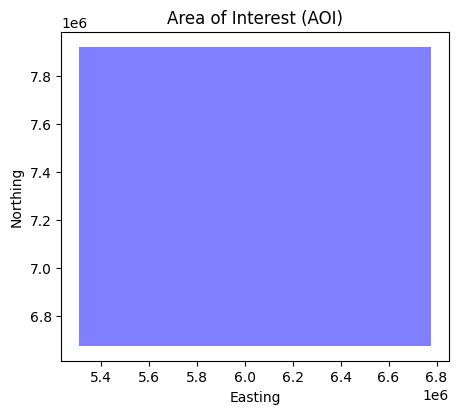

In [51]:
# Obter limites e montar objeto geoJSON
minx, miny, maxx, maxy = aoi_gdf.total_bounds
coords = [
    [minx, miny],
    [maxx, miny],
    [maxx, maxy],
    [minx, maxy],
    [minx, miny]   # fecha o poligono
]

aoi = {
    "type": "Polygon",
    "coordinates": [coords]
}

# Criar um polígono do entorno e exibir
aoi_polygon = Polygon(aoi['coordinates'][0])
aoi_gdf = gpd.GeoDataFrame(index=[0], geometry=[aoi_polygon])
aoi_gdf = aoi_gdf.set_crs(crs_projeto, inplace=True)

fig, ax = plt.subplots(figsize=(5, 5))
aoi_gdf.plot(ax=ax, color='blue', alpha=0.5)
ax.set_title('Area of Interest (AOI)')
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
plt.show()

**Upload dos dados preparados na Etapa 1**

In [52]:
grav_gdf = gpd.read_file("grav_gdf_copernicus.gpkg")
print(grav_gdf.head())

    LATITUDE  LONGITUDE   GRAV_OBS  ALT_ORT                source_file  \
0 -11.186133 -62.155065  978167.79   238.14  /content/bgi_20250221.zip   
1 -11.195567 -62.155110  978167.09   232.07  /content/bgi_20250221.zip   
2 -11.205559 -62.154960  978168.31   214.83  /content/bgi_20250221.zip   
3 -11.214858 -62.155118  978163.82   240.39  /content/bgi_20250221.zip   
4 -11.221462 -62.161604  978165.31   218.33  /content/bgi_20250221.zip   

   ALT_ORTCO                     geometry  
0        NaN  POINT (-62.15507 -11.18613)  
1        NaN  POINT (-62.15511 -11.19557)  
2        NaN  POINT (-62.15496 -11.20556)  
3        NaN  POINT (-62.15512 -11.21486)  
4        NaN   POINT (-62.1616 -11.22146)  


In [53]:
if grav_gdf.crs != aoi_gdf.crs:
    grav_gdf_proj = grav_gdf.to_crs(aoi_gdf.crs)
else:
    grav_gdf_proj = grav_gdf

# Function for keeping only points within the AOI
grav_gdf = gpd.sjoin(grav_gdf_proj, aoi_gdf, how="inner", predicate="within")
# drop the 'index_right' column added by sjoin
grav_gdf = grav_gdf.drop(columns=['index_right'])
print(f"Records in grav_gdf: {len(grav_gdf)}")
display(grav_gdf.head())

Records in grav_gdf: 77903


,LATITUDE,LONGITUDE,GRAV_OBS,ALT_ORT,source_file,ALT_ORTCO,geometry
1208,-26.726082,-49.484579,978933.06,518.47,/content/bgi_20250221.zip,518.086182,POINT (5449164.322 7034759.678)
1209,-26.733934,-49.478549,978933.21,517.52,/content/bgi_20250221.zip,522.671387,POINT (5449732.972 7033866.688)
1210,-26.744365,-49.478098,978934.66,522.08,/content/bgi_20250221.zip,520.868408,POINT (5449736.738 7032707.276)
1211,-26.752794,-49.473389,978937.82,517.02,/content/bgi_20250221.zip,517.515625,POINT (5450171.613 7031754.912)
1212,-26.757917,-49.464726,978938.57,517.93,/content/bgi_20250221.zip,517.563477,POINT (5451012.53 7031155.609)


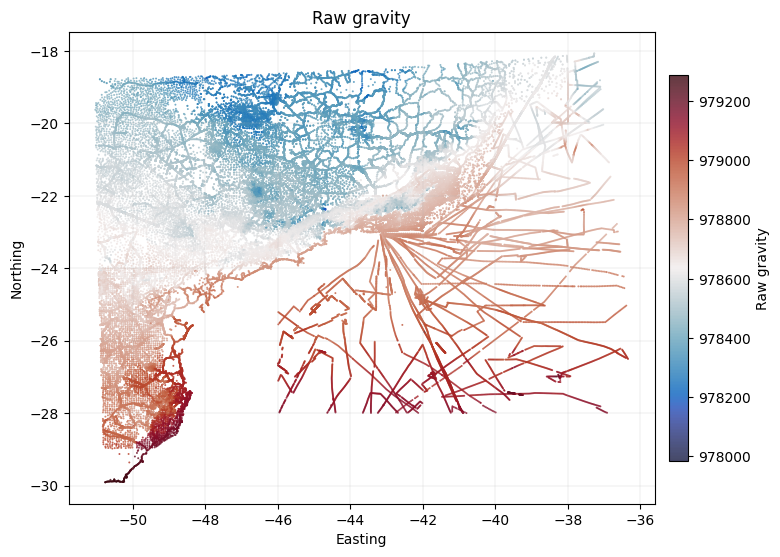

In [54]:
plot_gdf_scatter(x=grav_gdf["LONGITUDE"], y=grav_gdf["LATITUDE"], c=grav_gdf["GRAV_OBS"], cmap=cmocean.cm.balance, title="Raw gravity")

# **2. Redução dos dados**


##**2.1 Anomalia Ar-livre**

**Com o uso do Copernicus, não há o cálculo utilizando o geóide.**
O MDE COP-30 está referenciado em coordenadas geográficas WGS84 (datum horizontal) e altitude ortométrica referenciada ao modelo geoidal EGM2008 (datum vertical).

###### **Altitude ortométrica (H)**

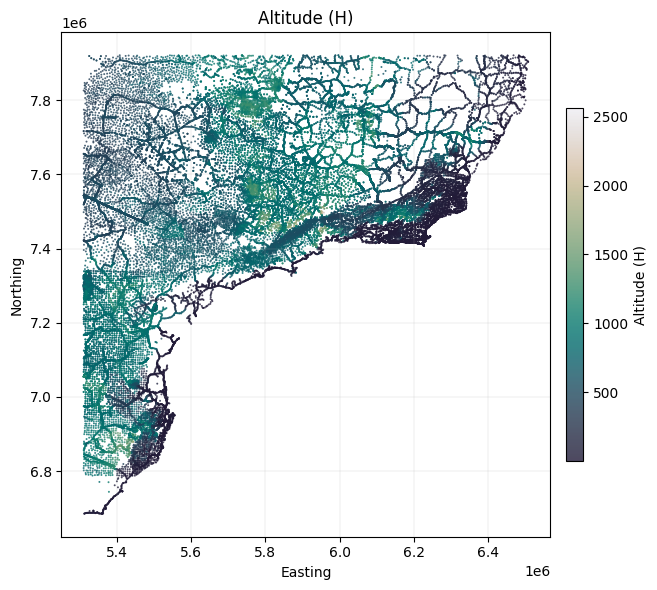

In [55]:
# Filtrar apenas registros com ALT_ORTCO numérico
mask = np.isfinite(grav_gdf["ALT_ORTCO"])
grav_gdf_plot = grav_gdf.loc[mask]

# Extrair coordenadas e valores
x = grav_gdf_plot.geometry.x.values
y = grav_gdf_plot.geometry.y.values
cop = grav_gdf_plot["ALT_ORTCO"].values  # altitude em metros

# Plot
plot_gdf_scatter(x=x, y=y, c=cop, cmap=cmocean.cm.rain_r, title="Altitude (H)")

## **2.2 Ar-livre terrestre**

A gravidade normal pode ser descrita como

$ γ(𝜑) = γe (1 + β sin²φ) $ *+ termos de ordem superior*

sendo γ a gravidade normal, γe a gravidade normal no equador, β um parâmetro que depende da forma da Terra e φ é a latitude.

Formula internacinal da gravidade (1980):

$ 𝛾(𝜑) = 978032.67715  *  (1 + 0.0052790414 sin²𝜑 + 0.0000232718  sin^4𝜑) $

Moritz, H. Geodetic reference system 1980. Bull. Geodesique 54, 395–405 (1980). https://doi.org/10.1007/BF02521480

In [56]:
# Calculo da Gravidade normal em mGal (GRS-80)
phi = np.deg2rad(grav_gdf.loc[mask, "LATITUDE"])
g_norm = 978032.67715 * ( 1 + 0.0052790414 * np.sin(phi)**2 - 0.0000232718 * np.sin(phi)**4)

In [57]:
# Altitude ortométrica H (m)
H = grav_gdf.loc[mask, "ALT_ORTCO"]

In [58]:
# Correção free-air: ΔgFA = 0.3086·H − 3.1·10⁻⁶·H²
FA = 0.3086 * H - 3.1e-6 * H**2

In [59]:
# Anomalia free-air δgFA = g_obs − g_norm + ΔgFA
dg_FA = grav_gdf.loc[mask, "GRAV_OBS"] - g_norm + FA

In [60]:
# Adicionar colunas ao GeoDataFrame
grav_gdf.loc[mask, "FA_CORR"] = FA
grav_gdf.loc[mask, "FA"] = dg_FA
grav_gdf_onshore = grav_gdf.loc[mask, ["LATITUDE","LONGITUDE","GRAV_OBS", "ALT_ORTCO","FA_CORR","FA", "geometry"]]

# Salvar backup
from google.colab import files
grav_gdf_onshore.to_file("/content/grav_fa_onshore.gpkg", driver="GPKG")
files.download('/content/grav_fa_onshore.gpkg')

grav_gdf_onshore

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,LATITUDE,LONGITUDE,GRAV_OBS,ALT_ORTCO,FA_CORR,FA,geometry
1208,-26.726082,-49.484579,978933.06,518.086182,159.049316,16.115110,POINT (5449164.322 7034759.678)
1209,-26.733934,-49.478549,978933.21,522.671387,160.449524,17.097782,POINT (5449732.972 7033866.688)
1210,-26.744365,-49.478098,978934.66,520.868408,159.898941,17.243218,POINT (5449736.738 7032707.276)
1211,-26.752794,-49.473389,978937.82,517.515625,158.875076,18.769859,POINT (5450171.613 7031754.912)
1212,-26.757917,-49.464726,978938.57,517.563477,158.889694,19.164027,POINT (5451012.53 7031155.609)
...,...,...,...,...,...,...,...
237888,-22.740000,-45.130000,978610.27,531.440735,163.127075,-30.243239,POINT (5910153.513 7456511.269)
237889,-22.770000,-45.150000,978612.64,537.578491,165.000854,-27.925433,POINT (5908403.819 7453915.086)
237890,-22.780000,-45.160000,978615.91,545.278625,167.351273,-22.947445,POINT (5907227.332 7452472.551)
237891,-22.800000,-45.170000,978623.15,541.261047,166.124969,-18.219265,POINT (5905702.163 7450008.659)


In [61]:
# Salvar grav_gdf_onshore como shapefile
base = '/content/grav_gdf_onshore'
grav_gdf_onshore.to_file(f'{base}.shp')
for ext in ('shp','shx','dbf','prj'):
    path = f'{base}.{ext}'
    if os.path.exists(path):
      files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

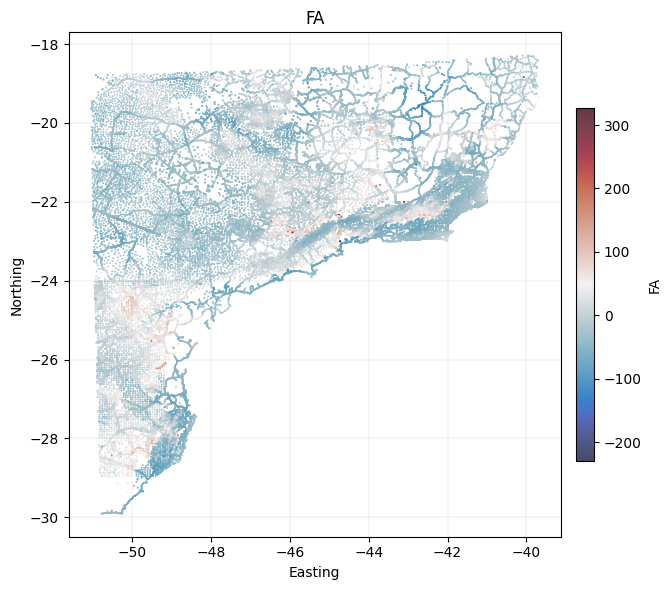

In [62]:
plot_gdf_scatter(x=grav_gdf_onshore["LONGITUDE"], y=grav_gdf_onshore["LATITUDE"], c=grav_gdf_onshore["FA"], cmap=cmocean.cm.balance, title="FA")

## **2.3 Marine Free-Air - Sandwell et al. 2014 (v32)**

Download .nc

In [63]:
import requests

url = "https://topex.ucsd.edu/pub/global_grav_1min/grav_32.1.nc"
filename = "grav_32.1.nc"

try:
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an exception for bad status codes
    with open(filename, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print(f"Downloaded {filename} successfully.")

except requests.exceptions.RequestException as e:
    print(f"Error downloading {url}: {e}")

Downloaded grav_32.1.nc successfully.


In [64]:
import xarray as xr
# Open the netCDF file
sandwell_ds = xr.open_dataset("/content/grav_32.1.nc")
print("Variáveis disponíveis:", list(sandwell_ds.data_vars))

Variáveis disponíveis: ['z']


Window FA data with AOI bounds

In [ ]:
# Convert aoi_gdf to WGS84 geographic coordinates (EPSG:4326)
aoi_gdf_wgs84 = aoi_gdf.to_crs(epsg=4326)

# Keep only data within the AOI bounds using the WGS84 bounds
minx, miny, maxx, maxy = aoi_gdf_wgs84.total_bounds
ds_sub = sandwell_ds.sel(
    lon=slice(minx, maxx),
    lat=slice(miny, maxy),
)

df = ds_sub["z"].to_dataframe(name="FA").reset_index()

# cria geometria
sandwell_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.lon, df.lat),
    crs="EPSG:4326"
)

print("Grav records", len(sandwell_gdf))

plot_gdf_scatter(x=sandwell_gdf["lon"], y=sandwell_gdf["lat"], c=sandwell_gdf["FA"], cmap=cmocean.cm.balance, title="FA Sandwell")

Grav records 659640


**Recorte para gravimetria offshore com raster de batimetria**

Obter batimetria de alta resolução

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin
import numpy as np
import pandas as pd

# Carregar CSV
df = pd.read_csv("/content/bat.csv")

# Criar GeoDataFrame com CRS da projeção do projeto ############# policônica Sirgas 2000 (EPSG:5880)
bat_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["X"], df["Y"]),
    crs=crs_projeto
)

bat_gdf.head()

From CSV to Raster

In [ ]:
# Limites da malha
minx, miny, maxx, maxy = bat_gdf.total_bounds

# Calcular largura e altura do raster de batimetria
# Definir resolução
res = 1000
width = int((maxx - minx) / res)
height = int((maxy - miny) / res)

# Definir a transformação affine
transform = from_origin(minx, maxy, res, res)

# Criar pares de (geometria, valor)
shapes = ((geom, value) for geom, value in zip(bat_gdf.geometry, bat_gdf["BAT"]))

# Rasterizar
raster = rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=np.nan,
    dtype="float32"
)

# Salvar GeoTIFF
with rasterio.open(
    "/content/bat_rasterized.tif",
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype="float32",
    crs=crs_projeto,
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(raster, 1)

In [ ]:
files.download('/content/bat_rasterized.tif')

In [ ]:
plot_gdf_scatter(x=bat_gdf["X"], y=bat_gdf["Y"], c=bat_gdf["BAT"], cmap=cmocean.cm.rain_r, title="Bathymetry")

File test

In [ ]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

bat_rasterized_path = '/content/bat_rasterized.tif'

# Open the raster file for testing
with rasterio.open(bat_rasterized_path) as src:
    bat_data = src.read(1)
    transform = src.transform
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    # Plot
    fig, ax = plt.subplots(figsize=(5, 5))
    show(bat_data, ax=ax, transform=transform, extent=extent, cmap=cmocean.cm.rain_r)

    ax.set_title('Bathymetry')
    ax.set_xlabel('Easting (m)')
    ax.set_ylabel('Northing (m)')
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
print(f"CRS of {bat_rasterized_path}: {src.crs}")

In [ ]:
import geopandas as gpd
import rasterio
import numpy as np

dem_path = '/content/bat_rasterized.tif'

with rasterio.open(dem_path) as dem:
    # Reproject grav GDF to raster CRS
    if sandwell_gdf.crs != dem.crs:
        sandwell_gdf = sandwell_gdf.to_crs(dem.crs)

    # Coorddinates with raster CRS
    coords = [(pt.x, pt.y) for pt in sandwell_gdf.geometry]
    # Sample DEM
    dem_vals = np.array([v[0] for v in dem.sample(coords)], dtype=np.float32)
    # From nodata to NaN
    if dem.nodata is not None:
        dem_vals[dem_vals == dem.nodata] = np.nan

print("Min value of DEM:", np.nanmin(dem_vals))
print("Max value of DEM:", np.nanmax(dem_vals))
print("Total of NaN values:", np.isnan(dem_vals).sum())

# Filtering where DEM <= 0
offshore_mask = dem_vals <= 0
sandwell_offshore_gdf = sandwell_gdf.loc[offshore_mask].copy()
sandwell_offshore_gdf["BAT"] = dem_vals[offshore_mask]

# Comparação
print(f"Number of points in grav_gdf: {len(grav_gdf)}")
print(f"Number of points in sandwell_offshore_gdf: {len(sandwell_offshore_gdf)}")
print(grav_gdf.columns)
sandwell_gdf.columns.rename('lat':'LATITUDE', 'lon':'LONGITUDE')
print(sandwell_offshore_gdf.columns)


In [ ]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os

# Input raster path (original bat_rasterized.tif in EPSG:5880)
input_dem_path = '/content/bat_rasterized.tif'
# Output raster path (reprojected DEM in EPSG:4326)
reprojected_dem_path = '/content/bat_rasterized_4326.tif'

# Target CRS (matching grav_gdf and sandwell_gdf)
target_crs = 'EPSG:4326'

with rasterio.open(input_dem_path) as src:
    # Calculate the transform and dimensions of the reprojected raster
    transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds
    )

    # Define the metadata for the output raster
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': target_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Reproject and save the raster
    with rasterio.open(reprojected_dem_path, 'w', **kwargs) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest # Use nearest neighbor for discrete data, or cubic/bilinear for continuous
        )

print(f"Reprojected DEM saved to {reprojected_dem_path}")

# Update the dem_path variable to point to the reprojected file
dem_path = reprojected_dem_path

In [ ]:
import geopandas as gpd
import rasterio
import numpy as np

dem_path = '/content/bat_rasterized.tif'

with rasterio.open(dem_path) as dem:
    # Reprojetar o GDF para o CRS do raster
    if sandwell_gdf.crs != dem.crs:
        sandwell_gdf_proj = sandwell_gdf.to_crs(dem.crs)
    else:
        sandwell_gdf_proj = sandwell_gdf

    # Criar lista de coordenadas no mesmo CRS do raster
    coords = [(pt.x, pt.y) for pt in sandwell_gdf_proj.geometry]

    # Amostrar o DEM nas coordenadas
    dem_vals = np.array([v[0] for v in dem.sample(coords)], dtype=np.float32)

    # Transformar nodata em NaN
    if dem.nodata is not None:
        dem_vals[dem_vals == dem.nodata] = np.nan

# Análises básicas
print("Valor mínimo do DEM:", np.nanmin(dem_vals))
print("Valor máximo do DEM:", np.nanmax(dem_vals))
print("Número de NaN no DEM:", np.isnan(dem_vals).sum())

# Filtrar onde DEM <= 0
offshore_mask = dem_vals <= 0
sandwell_offshore_gdf = sandwell_gdf.loc[offshore_mask].copy()  # manter CRS original
sandwell_offshore_gdf["BAT"] = dem_vals[offshore_mask]

# Comparação
print(f"Number of points in grav_gdf: {len(grav_gdf)}")
print(f"Number of points in sandwell_offshore_gdf: {len(sandwell_offshore_gdf)}")
print(grav_gdf.columns)
print(sandwell_offshore_gdf.columns)

In [ ]:
# Salvar backup
sandwell_offshore_gdf.to_file("/content/grav_fa_offshore.gpkg", driver="GPKG")
files.download('/content/grav_fa_offshore.gpkg')

In [ ]:
display(grav_gdf_terra.head(3))
display(sandwell_offshore_gdf.head(3))